In [1]:
%pip install numpy pandas matplotlib seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 294 kB 1.0 MB/s eta 0:00:01
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score 

import warnings
warnings.filterwarnings("ignore")


In [3]:
file_path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/GkDzb7bWrtvGXdPOfk6CIg/Obesity-level-prediction-dataset.csv"

df = pd.read_csv(file_path)
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


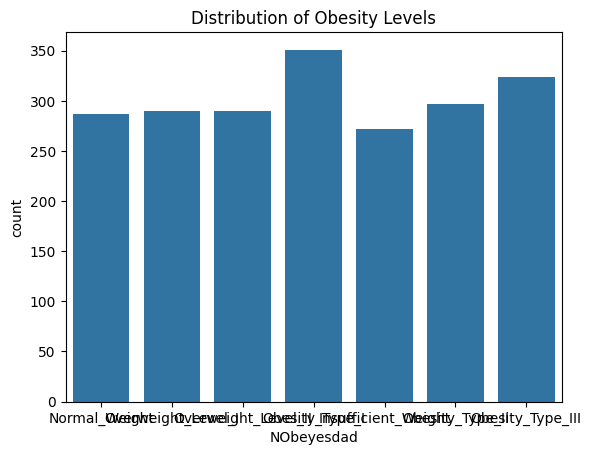

In [6]:
sns.countplot(x='NObeyesdad', data=df)
plt.title('Distribution of Obesity Levels')
plt.show()

In [8]:
print(df.isnull().sum())

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


In [10]:
counting_columns = df.select_dtypes(include=['float64']).columns.tolist()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[counting_columns])

scaled_df = pd.DataFrame(scaled_features, columns=scaler.get_feature_names_out(counting_columns))

scaled_data = pd.concat([scaled_df, df.drop(columns=counting_columns)], axis=1)

In [11]:
scaled_data.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
0,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,Female,yes,no,Sometimes,no,no,no,Public_Transportation,Normal_Weight
1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,Female,yes,no,Sometimes,yes,yes,Sometimes,Public_Transportation,Normal_Weight
2,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,Male,yes,no,Sometimes,no,no,Frequently,Public_Transportation,Normal_Weight
3,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,Male,no,no,Sometimes,no,no,Frequently,Walking,Overweight_Level_I
4,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,Male,no,no,Sometimes,no,no,Sometimes,Public_Transportation,Overweight_Level_II


In [13]:
categorial_columns = scaled_data.select_dtypes(include=['object']).columns.tolist()
categorial_columns.remove('NObeyesdad')

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(scaled_data[categorial_columns])

encoded_df = pd.DataFrame(encoded_features, columns = encoder.get_feature_names_out(categorial_columns))
prepped_data = pd.concat([scaled_data.drop(columns=categorial_columns), encoded_df], axis=1)


In [14]:
prepped_data['NObeyesdad'] = prepped_data['NObeyesdad'].astype('category').cat.codes
prepped_data.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,Gender_Male,family_history_with_overweight_yes,FAVC_yes,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,6,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [15]:
X = prepped_data.drop('NObeyesdad', axis=1)
y = prepped_data['NObeyesdad']


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
model_ova = LogisticRegression(multi_class='ovr', max_iter=1000)
model_ova.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='ovr')

In [19]:
y_pred = model_ova.predict(X_test)

print("One-vs-All Logistic Regression Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2))

One-vs-All Logistic Regression Accuracy: 76.12


In [20]:
model_ova = OneVsOneClassifier(LogisticRegression(max_iter=1000))
model_ova.fit(X_train, y_train)

OneVsOneClassifier(estimator=LogisticRegression(max_iter=1000))

In [21]:
y_pred_ova = model_ova.predict(X_test)

print("One-vs-One Logistic Regression Accuracy:", round(accuracy_score(y_test, y_pred_ova) * 100, 2))

One-vs-One Logistic Regression Accuracy: 92.2


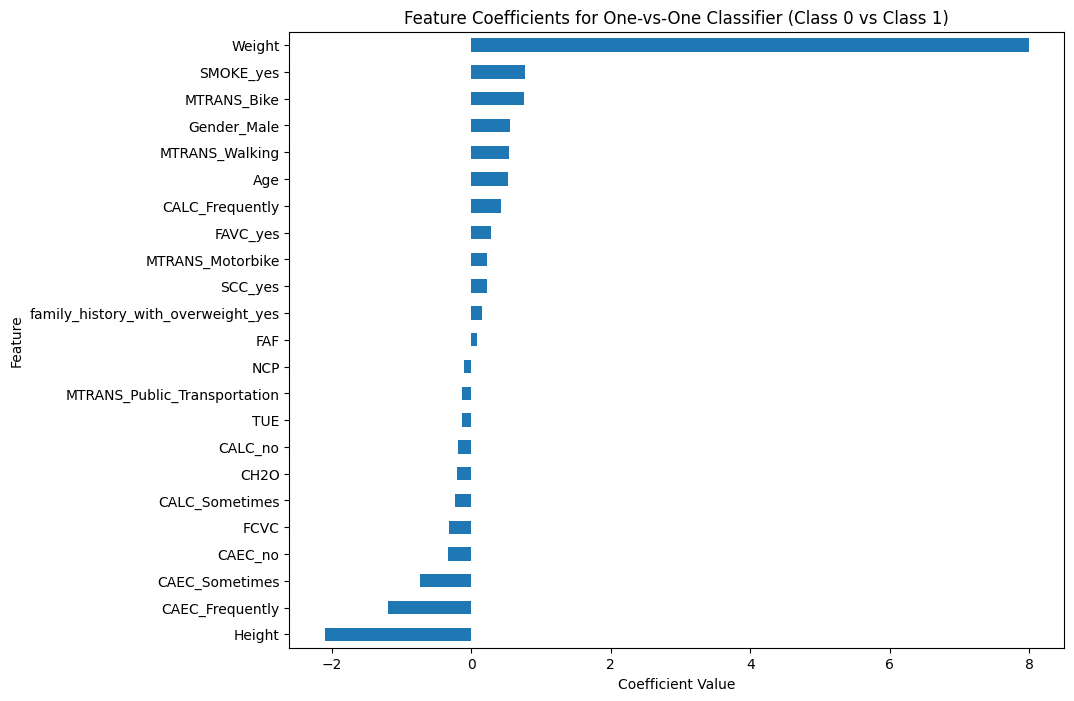

In [22]:
coeffs = pd.Series(model_ova.estimators_[0].coef_[0], index=X.columns)
coeffs.sort_values().plot(kind='barh', figsize=(10,8))
plt.title('Feature Coefficients for One-vs-One Classifier (Class 0 vs Class 1)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()


In [23]:

def obesity_risk_pipeline(data_path, test_size=0.2):
    df = pd.read_csv(data_path)
    counting_columns = df.select_dtypes(include=['float64']).columns.tolist()
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[counting_columns])
    scaled_df = pd.DataFrame(scaled_features, columns=scaler.get_feature_names_out(counting_columns))
    scaled_data = pd.concat([scaled_df, df.drop(columns=counting_columns)], axis=1)
    
    categorial_columns = scaled_data.select_dtypes(include=['object']).columns.tolist()
    categorial_columns.remove('NObeyesdad')
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_features = encoder.fit_transform(scaled_data[categorial_columns])
    encoded_df = pd.DataFrame(encoded_features, columns = encoder.get_feature_names_out(categorial_columns))
    prepped_data = pd.concat([scaled_data.drop(columns=categorial_columns), encoded_df], axis=1)
    
    prepped_data['NObeyesdad'] = prepped_data['NObeyesdad'].astype('category').cat.codes
    
    X = prepped_data.drop('NObeyesdad', axis=1)
    y = prepped_data['NObeyesdad']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    
    model_ova = OneVsOneClassifier(LogisticRegression(max_iter=1000))
    
    model_ova.fit(X_train, y_train)
    y_pred_ova = model_ova.predict(X_test)
    
    accuracy = round(accuracy_score(y_test, y_pred_ova) * 100, 2)
    
    return model_ova, accuracy


In [24]:
obesity_risk_pipeline(file_path, test_size=0.3)

(OneVsOneClassifier(estimator=LogisticRegression(max_iter=1000)), 90.85)